In [25]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Loading Data

Download zip files from github and unzip into mounted location. Once unzipped, read data files and load into dataframes.
Plot histogram to show label occurences

In [26]:
# Check if extracted data folder exists
usingColab = True
if usingColab:
  if(not os.path.exists('SYSC4415W23_A3_dataset')):

    # Download and extract the dataset if the zip file does not exist
    if (not os.path.isfile('SYSC4415W23_A3_dataset.zip')):
      !wget https://github.com/jrgreen7/SYSC4906/releases/download/Assignment3/SYSC4415W23_A3_dataset.zip
      !unzip SYSC4415W23_A3_dataset.zip


In [27]:
# Original Training Data
train_labels = pd.read_csv(f'SYSC4415W23_A3_dataset/train/labels.csv')
train_features = pd.read_csv(f'SYSC4415W23_A3_dataset/train/extracted_features.csv')

train_features.set_index(keys='sample_id', inplace=True)
train_labels.set_index(keys='sample_id', inplace=True)

train_features.sort_values(by=['sample_id'], inplace=True)
train_labels.sort_values(by=['sample_id'], inplace=True)

print(f'Shape of original features: {train_features.shape}')

# Evaluation Test Data
test_features = pd.read_csv(f'SYSC4415W23_A3_dataset/test/extracted_features.csv')
test_labels = pd.read_csv(f'SYSC4415W23_A3_dataset/test/labels.csv')

test_features.set_index('sample_id', inplace=True)
test_labels.set_index('sample_id', inplace=True)

test_features.sort_values(by=['sample_id'], inplace=True)
test_labels.sort_values(by=['sample_id'], inplace=True)

Shape of original features: (1621, 7047)


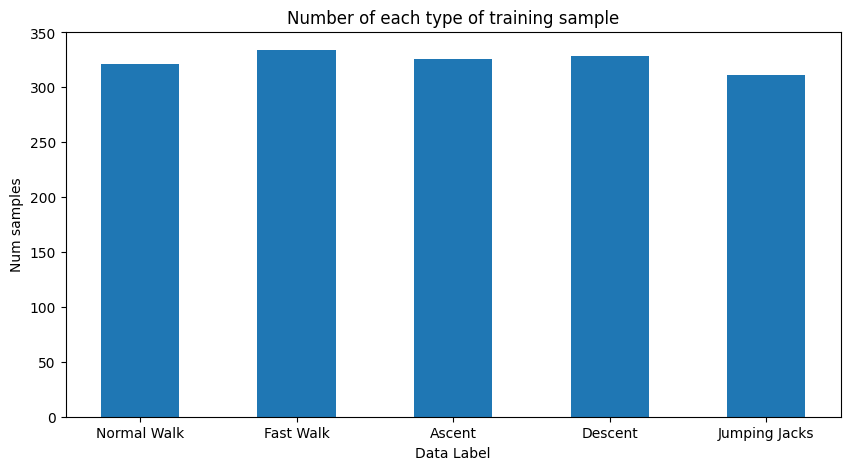

In [28]:
# Data visualization
counts = train_labels.value_counts(subset=['label'])
keys = ['Normal Walk', 'Fast Walk', 'Ascent', 'Descent', 'Jumping Jacks']
vals = [counts[0],counts[1], counts[2], counts[3], counts[4]]

fig = plt.figure(figsize=(10,5))
plt.bar(x=keys, height=vals, width=0.5)
plt.xlabel("Data Label")
plt.ylabel("Num samples")
plt.title("Number of each type of training sample")
plt.show()

# No class imbalance

### Feature Selection 
Using variance thresholding, dropping any features with NaN values and using univariate stats to determince the ***__top 50% of features__*** for classification to determine which features are useful.

In [29]:
# Remove features that have very low variance
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

# Feature Selection, done as a function to accomodate different features and methods needed by different models
def trimDataset(numFeatures: int, useCorr=False) -> tuple[pd.DataFrame, pd.DataFrame]:

    # Drop columns with nan values
    toDrop = train_features.columns[train_features.isnull().any()].tolist()
    train_selected = train_features.drop(toDrop, axis=1)
    test_selected = test_features.drop(toDrop, axis=1)

    # Drop columns with very low variance
    sel = VarianceThreshold(threshold=(0.95 * (1 - 0.95)))
    sel.fit_transform(train_selected)
    cols = [column for column in train_selected.columns 
            if column not in train_selected.columns[sel.get_support()]]
    train_selected.drop(columns=cols, inplace=True)
    test_selected.drop(columns=cols, inplace=True)

    # Compute the correlation matrix
    if useCorr:
        corr_matrix = train_selected.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        # Find index of feature columns with correlation greater than 0.8
        to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
        train_selected.drop(columns=to_drop, inplace=True)
        test_selected.drop(columns=to_drop, inplace=True)

        del to_drop

    # Using top 1750 features
    nextSel = SelectKBest(score_func=f_classif, k=numFeatures)
    nextSel.fit_transform(train_selected, train_labels['label'])
    cols = []
    cols = [column for column in train_selected.columns if column not in train_selected.columns[nextSel.get_support()]]
    train_selected.drop(columns=cols, inplace=True)
    test_selected.drop(columns=cols, inplace=True)

    # Free up memory for next tasks
    del toDrop, cols, sel, nextSel

    return train_selected, test_selected

# Extra Trees Model
**Model**

Using a Extremely Randomized Trees approach to classify samples, an ensemble learning method akin to Random Forests is used to determine class labels for examples. 

### Training

**Hyperparameters** 

The following hyperparameters were determined experimentally using a grid search method 
- Number of trees in Forest: 1000
- Loss Criterion: Log Loss
- Input size: 1250
- Output size: 5

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
import time, random

# Dataset Preparation
jobs = -1
dataset, evalSet = trimDataset(1250, False)
dataset.sort_values(by=['sample_id'], inplace=True); evalSet.sort_values(by=['sample_id'], inplace=True)
randomState = random.randrange(0, 400)

print(dataset.shape, ' --> Dataset shape prior to training')

trainData, testData, trainLabels, testLabels = train_test_split(dataset, train_labels, shuffle=True, test_size=0.2, random_state=randomState)

# Model Training
eTree = ExtraTreesClassifier(n_estimators=1000, min_samples_split=2, max_features=None, n_jobs=jobs, criterion='log_loss')

start = time.time()
eTree.fit(trainData, trainLabels.values.ravel())
totalTime = time.time() - start
print(f'ETrees Training time: {round(totalTime, ndigits=2)} s')

(1621, 1250)  --> Dataset shape prior to training
ETrees Training time: 14.27 s


### Testing

Testing model using 20% of the original dataset used as a holdout for validation. 

In [31]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Extra Trees
trainLabelsEx = pd.Series(data=eTree.predict(X=trainData), index=trainData.index) # output trainData.shape
testLabelsEx = pd.Series(data=eTree.predict(X=testData), index=testData.index)    # output testData.shape

tr_score = accuracy_score(trainLabels, trainLabelsEx)
te_score = accuracy_score(testLabels,  testLabelsEx)

print(f"Train accuracy ETrees: {round(tr_score*100, 2)}%")
print(f"Test accuracy ETrees:  {round(te_score*100, 2)}%")

score = cross_val_score(eTree, X=dataset, y=train_labels, cv=5, n_jobs=jobs, scoring='accuracy')
print("5-fold Cross validation score on eTree model")
print(f"Score: {score.mean()*100: .2f}% \t[± {score.std()*100: .2f}%]")

Train accuracy ETrees: 100.0%
Test accuracy ETrees:  82.46%
5-fold Cross validation score on eTree model
Score:  78.22% 	[±  2.49%]


# SVM Classifier
**Hyperparameters**
- Kernel: Linear
- Regularization constant (C): 1.0
- Input size: 1750
- Output size: 5

In [32]:
from sklearn.model_selection import train_test_split

dataset, evalSet = trimDataset(1750, False)
trainX, testX, trainY, testY = train_test_split(dataset, train_labels, shuffle=True, test_size=0.2, random_state=randomState)

from sklearn import svm
svm_model = svm.SVC(kernel='linear', C = 1.0, probability=True)

svm_model.fit(trainX, trainY.values.ravel())

SVC(kernel='linear', probability=True)

In [33]:
from sklearn.metrics import accuracy_score

train_pred = svm_model.predict(trainX)
test_pred = svm_model.predict(testX)

print("====== Training dataset results ======")
print(f"Training accuracy: {accuracy_score(trainY, train_pred)*100: .2f}%")
print("====== Validation dataset results ======")
print(f"Testing accuracy: {accuracy_score(testY, test_pred)*100: .2f}%")

score = cross_val_score(svm_model, X=dataset, y=train_labels, cv=5, n_jobs=jobs, scoring='accuracy')
print("5-fold Cross validation score on eTree model")
print(f"Score: {score.mean()*100: .2f}%\t[± {score.std()*100: .2f}%]")

====== Training dataset results ======
Training accuracy:  100.00%
====== Validation dataset results ======
Testing accuracy:  70.77%
5-fold Cross validation score on eTree model
Score:  71.13%	[±  2.64%]


# XGBoost Classifier
**Model Hyperparameters**
- Number of trees in Forest: 1000
- Input size: 1250
- Output size: 5

In [34]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Dataset Preparation
dataset, evalSet = trimDataset(1250, True)
dataset.sort_values(by=['sample_id'], inplace=True); evalSet.sort_values(by=['sample_id'], inplace=True)

print(dataset.shape, '- Dataset shape prior to training')

xgb_cl = xgb.XGBClassifier(n_estimators=1000, max_features=None, n_jobs=jobs)

trainData, testData, trainLabels, testLabels = train_test_split(dataset, train_labels, shuffle=True, test_size=0.2, random_state=randomState)

start = time.time()
xgb_cl.fit(trainData, trainLabels)
totalTime = time.time() - start
print(f'XGBoost Training time: {round(totalTime, ndigits=2)} s')

test_preds = xgb_cl.predict(testData)

(1621, 1250) - Dataset shape prior to training
XGBoost Training time: 20.1 s


In [35]:
from sklearn.model_selection import cross_val_score

a_s1 = accuracy_score(testLabels, test_preds)*100

print("====== Validation dataset results ======")
print(f"Testing accuracy: {a_s1: .2f}%")

scores_2 = cross_val_score(xgb_cl, dataset, train_labels, cv=5, n_jobs=jobs)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_2.mean()*100, scores_2.std()*100))

====== Validation dataset results ======
Testing accuracy:  77.23%
72.42 accuracy with a standard deviation of 2.81


# Model Stacking
### Technique: Voting

In [36]:
from sklearn.ensemble import VotingClassifier

# Dataset Preparation
dataset, evalSet = trimDataset(1500, False)
dataset.sort_values(by=['sample_id'], inplace=True); evalSet.sort_values(by=['sample_id'], inplace=True)
trainX, testX, trainY, testY = train_test_split(dataset, train_labels, shuffle=True, test_size=0.2, random_state=randomState)

# Voting Classifier setup
vote_cl = VotingClassifier(estimators=[('svc', svm_model), ('xgb', xgb_cl), ('eTree', eTree)], n_jobs=jobs, voting='soft')

vote_cl.fit(X=trainX, y=trainY.values.ravel())

VotingClassifier(estimators=[('svc', SVC(kernel='linear', probability=True)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_features=None, max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=1000, n_jobs=-1,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...)),
                             ('eTree',
                              ExtraTreesClassifier(criterion='log_loss',
                                                   max_features=None,
                                                   n_estimators=1000,
                                                   n_jobs=-1))],
                 n_jobs=-1, voting='soft')

In [37]:
vote_labels = vote_cl.predict(X=testX)
vote_score = accuracy_score(testY, vote_labels)
print(f"Voting accuracy: {round(vote_score*100, 2)}%")

score = cross_val_score(vote_cl, X=dataset, y=train_labels, cv=5, n_jobs=jobs, scoring='accuracy')
print("5-fold Cross validation score on Voting combination model")
print(f"Score: {score.mean()*100: .2f}\t[± {score.std()*100: .2f}]")

Voting accuracy: 80.92%
5-fold Cross validation score on Voting combination model
Score:  78.35	[±  3.74]


In [38]:
import pickle

fname = f'vote_cl_acc{int(vote_score*100)}'
pickle.dump(vote_cl, open(fname, 'wb'))

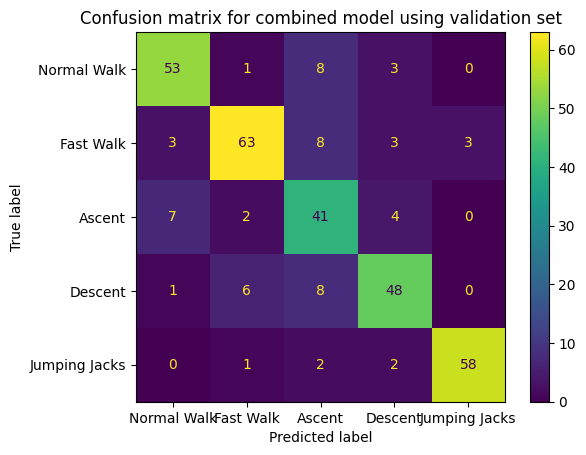

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay

label_names = ['Normal Walk', 'Fast Walk', 'Ascent', 'Descent', 'Jumping Jacks']
cm = confusion_matrix(vote_labels, testY)
matrix = ConfusionMatrixDisplay(cm, display_labels=label_names)
matrix.plot(); plt.title('Confusion matrix for combined model using validation set'); plt.show(); matrix.figure_.savefig('submission/confMatrix.png')

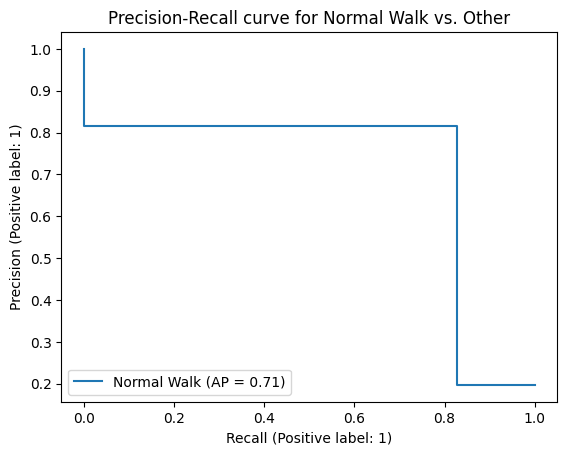

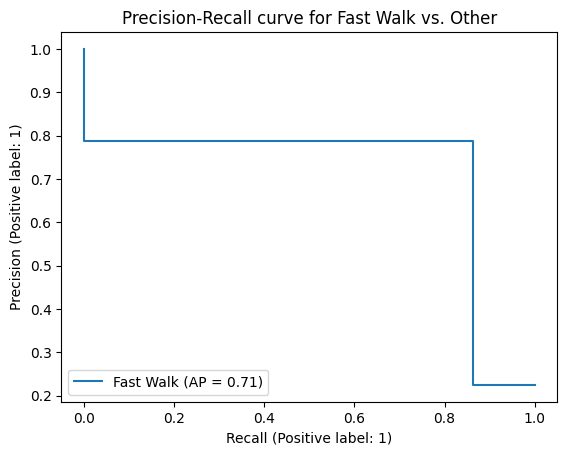

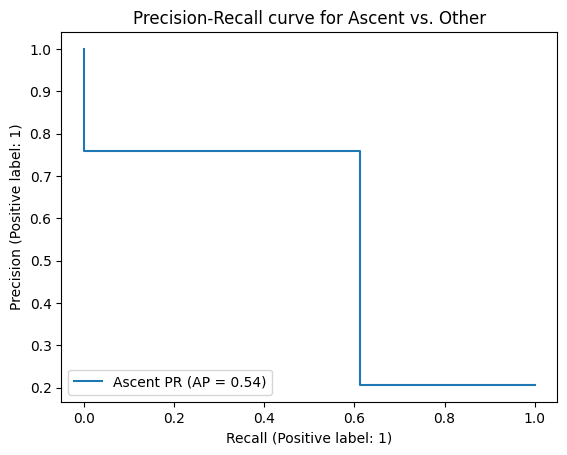

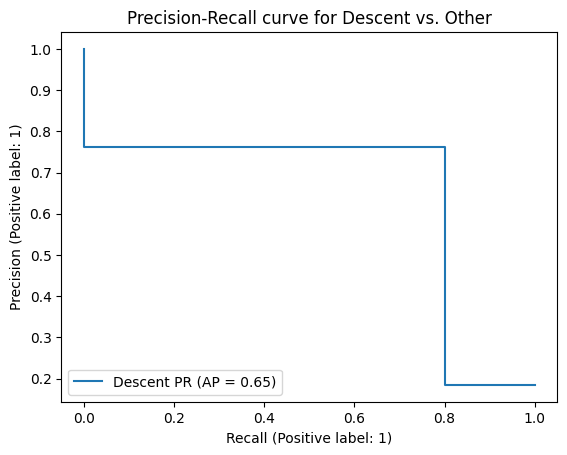

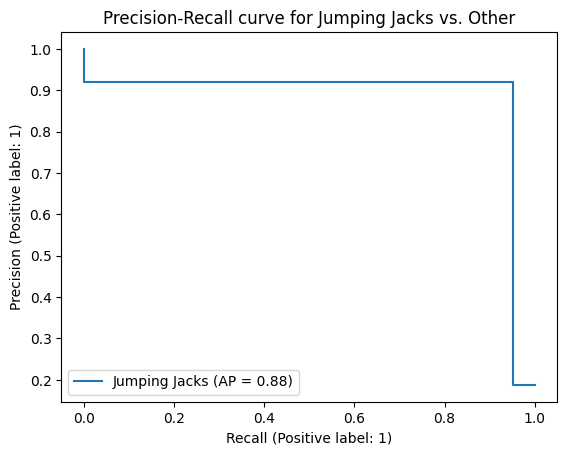

In [40]:
def convert_bin(label_list, pos_label):
  conv_list = []
  for idx in range(len(label_list)):
    conv_list += [1 if label_list[idx] == pos_label else 0]
  return conv_list

# Normal Walk PR Curve
true = convert_bin(vote_labels, 0)
pred = convert_bin(testY.to_numpy(), 0)

normal_pr = PrecisionRecallDisplay.from_predictions(pred, true, name="Normal Walk")
normal = normal_pr.ax_.set_title("Precision-Recall curve for Normal Walk vs. Other")
normal_pr.figure_.savefig('submission/normal_pr.png')

# Fast Walk PR Curve
true = convert_bin(vote_labels, 1)
pred = convert_bin(testY.to_numpy(), 1)

fast_pr = PrecisionRecallDisplay.from_predictions(pred, true, name="Fast Walk")
fast = fast_pr.ax_.set_title("Precision-Recall curve for Fast Walk vs. Other")
fast_pr.figure_.savefig('submission/fast_pr.png')

# Ascent PR Curve
true = convert_bin(vote_labels, 2)
pred = convert_bin(testY.to_numpy(), 2)

ascent_pr = PrecisionRecallDisplay.from_predictions(pred, true, name="Ascent PR")
ascent = ascent_pr.ax_.set_title("Precision-Recall curve for Ascent vs. Other")
ascent_pr.figure_.savefig('submission/ascent_pr.png')

# Descent PR Curve
true = convert_bin(vote_labels, 3)
pred = convert_bin(testY.to_numpy(), 3)

descent_pr = PrecisionRecallDisplay.from_predictions(pred, true, name="Descent PR")
descent = descent_pr.ax_.set_title("Precision-Recall curve for Descent vs. Other")
descent_pr.figure_.savefig('submission/descent_pr.png')

# Jumping Jacks PR Curve
true = convert_bin(vote_labels, 4)
pred = convert_bin(testY.to_numpy(), 4)

jump_pr = PrecisionRecallDisplay.from_predictions(pred, true, name="Jumping Jacks")
jump = jump_pr.ax_.set_title("Precision-Recall curve for Jumping Jacks vs. Other")
jump_pr.figure_.savefig('submission/jump_pr.png')